In [5]:
from scripts_fermions.operators import Hamiltonian, Boost

import glob
import os

import matplotlib.pyplot as plt
import numpy as np

import yastn
import yastn.tn.mps as mps


In [6]:
g = 1
v, Q = 1, 1
N = 128
D = 64
a = 0.25
m = 0.5
#
glob_path = os.path.join(os.path.abspath(""), "./results_fermions/g=1.0000/**/ex/**/state_D=*.npy")
fnames = glob.glob(glob_path, recursive=True)
fex = sorted([fname for fname in fnames if all(x in fname for x in ["/g=1.0000/", f"{N=}", f"{a=:0.4f}", f"{D=}"])])
#
glob_path = os.path.join(os.path.abspath(""), "./results_fermions/g=1.0000/**/gs/**/state_D=*.npy")
fnames = glob.glob(glob_path, recursive=True)
fgs = sorted([fname for fname in fnames if all(x in fname for x in ["/g=1.0000/", f"{N=}", f"{a=:0.4f}", f"{D=}"])])

def fn_mass(fns, **kwargs):
    return [x for x in fns if all( f"{k}={v}" in x for k, v in kwargs.items()) ][0]

ops = yastn.operators.SpinlessFermions(sym='U1', tensordot_policy='no_fusion')
d_ex = np.load(fn_mass(fex, m=m), allow_pickle=True).item()
d_gs = np.load(fn_mass(fgs, m=m), allow_pickle=True).item()


In [7]:
t = 0
v = 1
Q = 0

H = Hamiltonian(N, m, g, t, a, v, Q, ops)
K = Boost(N, m, g, a, ops)

psi_ex = yastn.from_dict(d_ex['psi'])
psi_gs = yastn.from_dict(d_gs['psi'])

E_ex = mps.vdot(psi_ex, H, psi_ex).real
E_gs = mps.vdot(psi_gs, H, psi_gs).real

print(E_ex)
print(E_gs)
print(E_ex - E_gs)


-162.65169261518065
-164.19848059660316
1.5467879814225114


In [8]:
psi = psi_ex.copy()

opts_svd={"D_total": 64}
chis = np.linspace(0, 1, 21)

opts_expmv = {'hermitian': True, 'tol': 1e-10}
evol = mps.tdvp_(psi, K, chis, method='12site', opts_svd=opts_svd, dt=0.05, yield_initial=True, precompute=False, subtract_E=True, opts_expmv=opts_expmv)

EE = []
EE2 = []

for info in evol:
    EE.append(mps.vdot(psi, H, psi))
    EE2.append(mps.vdot(psi, H @ H, psi))
    print(f"{info.tf:0.2f}", EE[-1].real, EE2[-1].real - (EE[-1].real) ** 2)

0.00 -162.65169261518065 5.4504198487848043e-08
0.05 -162.64970794057672 0.00024337859940715134
0.10 -162.64397469462722 0.00032351724803447723
0.15 -162.6344821689404 0.00038253230013651773
0.20 -162.62115362958482 0.0005012533365515992
0.25 -162.60394064673986 0.000726166970707709
0.30 -162.58283655702056 0.0009975247594411485
0.35 -162.5578214520034 0.0013040732592344284
0.40 -162.5288562933459 0.0016368330943805631
0.45 -162.4958778628158 0.0020217356650391594
0.50 -162.45881824249363 0.0024853245631675236
0.55 -162.41762334472043 0.003004017267812742
0.60 -162.3722280369424 0.0035998384955746587
0.65 -162.3225728363271 0.004236674645653693
0.70 -162.2685728611165 0.00495923709240742
0.75 -162.21015163420893 0.0057564068483770825
0.80 -162.14722941915232 0.006637065849645296
0.85 -162.07972440820382 0.007621241908054799
0.90 -162.0075677004777 0.008677779544086661
0.95 -161.93066981214852 0.00986663998264703
1.00 -161.84897266094669 0.011132432493468514


Text(0.5, 0, 'chi')

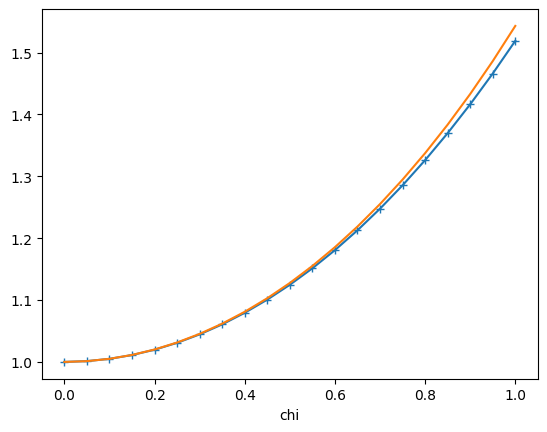

In [10]:
dE = np.array(EE).real - E_gs
plt.plot(chis, dE / dE[0], '-+')
plt.plot(chis, np.cosh(chis))
plt.xlabel("chi")
